In [1]:
!pip install pyspark

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.0/317.0 MB 2.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.5.1-py2.py3-none-any.whl size=317488491 sha256=5042716765b37b87a5f37a39265670a2c121d8e1004cd6c4620fddb86ae20896
  Stored in directory: /root/.cache/pip/wheels/80/1d/60/2c256ed38dddce2fdd93be545214a63e02fbd8d74fb0b7f3a6
Successfully built pyspark


In [2]:
import numpy as np
import pandas as pd
import os
import pyspark
from pyspark.sql import SparkSession
from pyspark.sql.types import StructType, StructField, IntegerType, StringType

from pyspark.sql.functions import round
from pyspark.ml.feature import StringIndexer
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import MulticlassClassificationEvaluator, BinaryClassificationEvaluator

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

In [3]:
spark = SparkSession.builder \
                    .master('local[*]') \
                    .appName('ML with PySpark') \
                    .getOrCreate()
# What version of Spark?
print(spark.version)

3.5.1


In [4]:
from google.colab import files

uploaded = files.upload()

Saving flights-larger.csv to flights-larger.csv


# Loading Dataset

In [5]:
flights_df = spark.read.csv('flights-larger.csv',
                         sep=',',
                         header=True,
                         inferSchema=True,
                         nullValue='NA')

# Data Exploration

In [6]:
# Get number of records
print("The data contain %d records." % flights_df.count())
# View the first five records
flights_df.show(5)

The data contain 275000 records.
+---+---+---+-------+------+---+----+------+--------+-----+
|mon|dom|dow|carrier|flight|org|mile|depart|duration|delay|
+---+---+---+-------+------+---+----+------+--------+-----+
| 10| 10|  1|     OO|  5836|ORD| 157|  8.18|      51|   27|
|  1|  4|  1|     OO|  5866|ORD| 466|  15.5|     102| NULL|
| 11| 22|  1|     OO|  6016|ORD| 738|  7.17|     127|  -19|
|  2| 14|  5|     B6|   199|JFK|2248| 21.17|     365|   60|
|  5| 25|  3|     WN|  1675|SJC| 386| 12.92|      85|   22|
+---+---+---+-------+------+---+----+------+--------+-----+
only showing top 5 rows



In [7]:
# Check column data types
print(flights_df.dtypes)

[('mon', 'int'), ('dom', 'int'), ('dow', 'int'), ('carrier', 'string'), ('flight', 'int'), ('org', 'string'), ('mile', 'int'), ('depart', 'double'), ('duration', 'int'), ('delay', 'int')]


# Data Pre-paration

In [8]:
# Remove the 'flight' column
flights_df =  flights_df.drop('flight')

# Remove records with missing values
flights_df = flights_df.dropna()
print("Count:",flights_df.count())

Count: 258289


In [9]:
# Convert columns 'mile' to 'km' and then drop it
flights_km = flights_df.withColumn('km', round(flights_df.mile * 1.60934, 0)) \
                    .drop('mile')

# Create 'label' column indicating whether a flight is delayed or not
flights_km = flights_km.withColumn('label', (flights_km.delay >= 15).cast('integer'))

# Check first five records
flights_km.show(5)

+---+---+---+-------+---+------+--------+-----+------+-----+
|mon|dom|dow|carrier|org|depart|duration|delay|    km|label|
+---+---+---+-------+---+------+--------+-----+------+-----+
| 10| 10|  1|     OO|ORD|  8.18|      51|   27| 253.0|    1|
| 11| 22|  1|     OO|ORD|  7.17|     127|  -19|1188.0|    0|
|  2| 14|  5|     B6|JFK| 21.17|     365|   60|3618.0|    1|
|  5| 25|  3|     WN|SJC| 12.92|      85|   22| 621.0|    1|
|  3| 28|  1|     B6|LGA| 13.33|     182|   70|1732.0|    1|
+---+---+---+-------+---+------+--------+-----+------+-----+
only showing top 5 rows



In [10]:
# Create an indexer, which identifies categories and then creates a new column with numeric index values
flights_indexed = StringIndexer(inputCol='carrier', outputCol='carrier_idx').fit(flights_km).transform(flights_km)

# Repeat the process for org column
flights_indexed = StringIndexer(inputCol='org', outputCol='org_idx').fit(flights_indexed).transform(flights_indexed)
flights_indexed.show(5)

+---+---+---+-------+---+------+--------+-----+------+-----+-----------+-------+
|mon|dom|dow|carrier|org|depart|duration|delay|    km|label|carrier_idx|org_idx|
+---+---+---+-------+---+------+--------+-----+------+-----+-----------+-------+
| 10| 10|  1|     OO|ORD|  8.18|      51|   27| 253.0|    1|        2.0|    0.0|
| 11| 22|  1|     OO|ORD|  7.17|     127|  -19|1188.0|    0|        2.0|    0.0|
|  2| 14|  5|     B6|JFK| 21.17|     365|   60|3618.0|    1|        4.0|    2.0|
|  5| 25|  3|     WN|SJC| 12.92|      85|   22| 621.0|    1|        3.0|    5.0|
|  3| 28|  1|     B6|LGA| 13.33|     182|   70|1732.0|    1|        4.0|    3.0|
+---+---+---+-------+---+------+--------+-----+------+-----+-----------+-------+
only showing top 5 rows



In [11]:
# Create an assembler object
assembler = VectorAssembler(inputCols=['mon', 'dom', 'dow',
'carrier_idx', 'org_idx', 'km', 'depart', 'duration'], outputCol='features')
# Consolidate predictor columns
flights_assembled = assembler.transform(flights_indexed)
# Check the resulting column
flights_assembled.select('features', 'delay').show(5, truncate=False)


+-----------------------------------------+-----+
|features                                 |delay|
+-----------------------------------------+-----+
|[10.0,10.0,1.0,2.0,0.0,253.0,8.18,51.0]  |27   |
|[11.0,22.0,1.0,2.0,0.0,1188.0,7.17,127.0]|-19  |
|[2.0,14.0,5.0,4.0,2.0,3618.0,21.17,365.0]|60   |
|[5.0,25.0,3.0,3.0,5.0,621.0,12.92,85.0]  |22   |
|[3.0,28.0,1.0,4.0,3.0,1732.0,13.33,182.0]|70   |
+-----------------------------------------+-----+
only showing top 5 rows



# Machine Learning Models

**Decision** **Tree**

In [12]:
# Split into training and testing sets in a 80:20 ratio
flights_train, flights_test = flights_assembled.randomSplit([0.8, 0.2], seed=42)

# Check that training set has around 80% of records
training_ratio = flights_train.count() / flights_assembled.count()
print("Traning Ratio:",training_ratio)

Traning Ratio: 0.7997359546864171


In [13]:
# Create a DT classifier object and fit to the training data
tree = DecisionTreeClassifier()
tree_model = tree.fit(flights_train)
# Create predictions on test data
prediction = tree_model.transform(flights_test)
prediction.select('label', 'prediction', 'probability').show(5, False)

+-----+----------+----------------------------------------+
|label|prediction|probability                             |
+-----+----------+----------------------------------------+
|0    |1.0       |[0.31652434802677126,0.6834756519732287]|
|1    |1.0       |[0.31652434802677126,0.6834756519732287]|
|0    |1.0       |[0.31652434802677126,0.6834756519732287]|
|0    |1.0       |[0.4300202839756592,0.5699797160243407] |
|0    |1.0       |[0.31652434802677126,0.6834756519732287]|
+-----+----------+----------------------------------------+
only showing top 5 rows



In [14]:
# Create a confusion matrix
prediction.groupBy('label', 'prediction').count().show()

# Calculate the elements of the confusion matrix
TN = prediction.filter('prediction = 0 AND label = prediction').count()
TP = prediction.filter('prediction = 1 AND label = prediction').count()
FN = prediction.filter('prediction = 0 AND label != prediction').count()
FP = prediction.filter('prediction = 1 AND label != prediction').count()

# Accuracy measures the proportion of correct predictions
accuracy = (TN + TP) / (TN + TP + FN + FP)
print("Accuracy of Decision Tree:", accuracy)


+-----+----------+-----+
|label|prediction|count|
+-----+----------+-----+
|    1|       0.0| 9159|
|    0|       0.0|16433|
|    1|       1.0|16734|
|    0|       1.0| 9400|
+-----+----------+-----+

Accuracy of Decision Tree: 0.6412055832656691


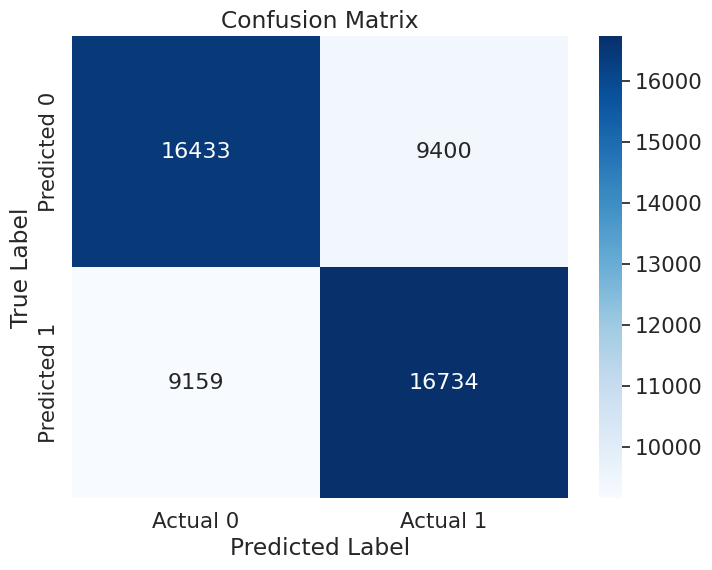

In [15]:
# Create a confusion matrix DataFrame
confusion_matrix_df = pd.DataFrame({
    'Actual 0': [TN, FN],
    'Actual 1': [FP, TP]
}, index=['Predicted 0', 'Predicted 1'])

# Plotting the heatmap
plt.figure(figsize=(8, 6))
sns.set(font_scale=1.4)  # Adjust the font size
sns.heatmap(confusion_matrix_df, annot=True, fmt='d', cmap='Blues', annot_kws={"size": 16})
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

**Logistic Regression**

In [16]:
# Create a classifier object and train on training data
logistic = LogisticRegression().fit(flights_train)
# Create predictions for the testing data and show confusion matrix
prediction = logistic.transform(flights_test)
prediction.groupBy('label', 'prediction').count().show()

+-----+----------+-----+
|label|prediction|count|
+-----+----------+-----+
|    1|       0.0| 9378|
|    0|       0.0|15026|
|    1|       1.0|16515|
|    0|       1.0|10807|
+-----+----------+-----+



In [17]:
# Calculate precision and recall
precision = TP / (TP + FP)
recall = TP / (TP + FN)
print('precision = {:.2f}\nrecall    = {:.2f}'.format(precision, recall))

# Find weighted precision
multi_evaluator = MulticlassClassificationEvaluator()
weighted_precision = multi_evaluator.evaluate(prediction, {multi_evaluator.metricName: "weightedPrecision"})

# Find AUC
binary_evaluator = BinaryClassificationEvaluator()
auc = binary_evaluator.evaluate(prediction, {binary_evaluator.metricName: "areaUnderROC"})



precision = 0.64
recall    = 0.65


In [18]:
# Calculate F1 score
f1_score = 2 * (precision * recall) / (precision + recall)
print('F1 Score = {:.2f}'.format(f1_score))

F1 Score = 0.64


In [19]:
# Confusion matrix values
TN = 14934
TP = 16544
FN = 9471
FP = 10741

# Calculate accuracy
accuracy = (TN + TP) / (TN + TP + FN + FP)
print(f'Accuracy: {accuracy:.4f}')

Accuracy: 0.6090


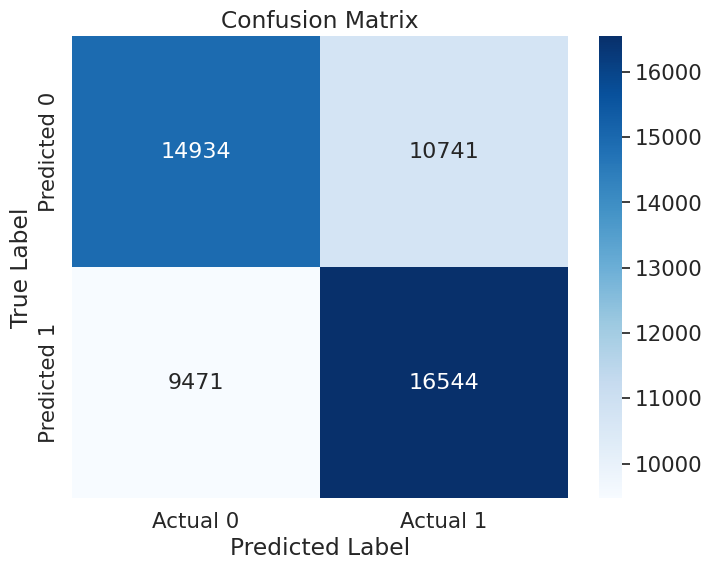

In [20]:
# Create a confusion matrix DataFrame
confusion_matrix_df = pd.DataFrame({
    'Actual 0': [TN, FN],
    'Actual 1': [FP, TP]
}, index=['Predicted 0', 'Predicted 1'])

# Plot the heatmap
plt.figure(figsize=(8, 6))
sns.set(font_scale=1.4)  # Adjust the font size
sns.heatmap(confusion_matrix_df, annot=True, fmt='d', cmap='Blues', annot_kws={"size": 16})
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()


In [26]:
from pyspark.ml.linalg import Vectors, VectorUDT
from pyspark.sql.functions import udf, lit, col
from pyspark.sql.types import DoubleType

# Define a UDF to extract components from the features vector
def extract_component(vector, index):
    return float(vector[index])

# Register the UDF
extract_component_udf = udf(extract_component, DoubleType())

# Mapping of original column names to their indices in the features vector
original_columns = ['mon', 'dom', 'dow', 'carrier_idx', 'org_idx', 'km', 'depart', 'duration']

# Create separate columns for each component of the features vector
for i, col_name in enumerate(original_columns):
    flights_assembled = flights_assembled.withColumn(col_name, extract_component_udf('features', lit(i)))

# Calculate variance for each original column
variances = flights_assembled.select([var_pop(col(col_name)).alias(col_name + '_variance') for col_name in original_columns])

# Show the variance values
variances.show()


+------------------+-----------------+-----------------+--------------------+-----------------+------------------+------------------+-----------------+
|      mon_variance|     dom_variance|     dow_variance|carrier_idx_variance| org_idx_variance|       km_variance|   depart_variance|duration_variance|
+------------------+-----------------+-----------------+--------------------+-----------------+------------------+------------------+-----------------+
|11.626260699904696|77.35918894140129|3.870172411073463|  3.6827571858940504|3.392228551576731|1289083.3967538856|21.987909036295658|7677.656851787339|
+------------------+-----------------+-----------------+--------------------+-----------------+------------------+------------------+-----------------+



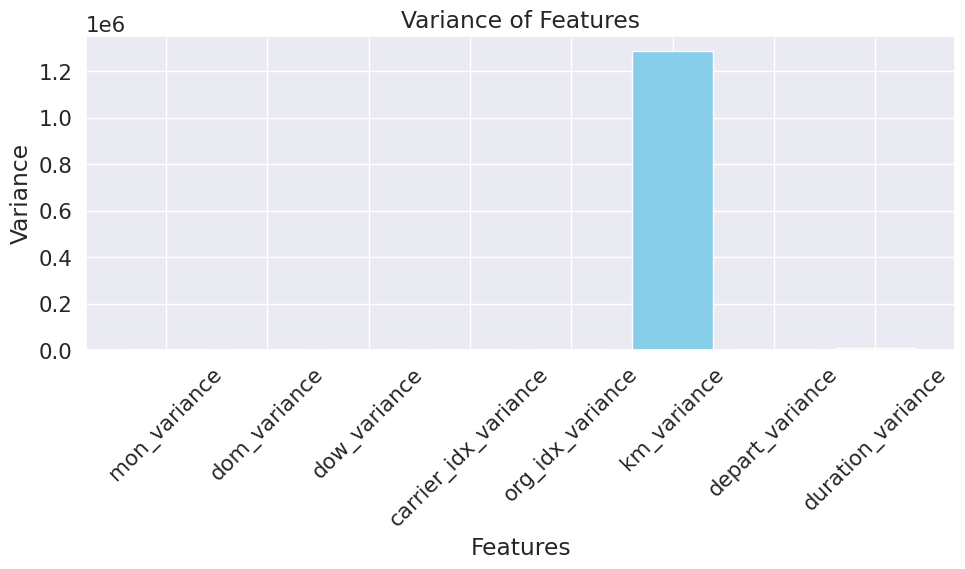

In [25]:
from pyspark.ml.linalg import Vectors, VectorUDT
from pyspark.sql.functions import udf, lit, col
from pyspark.sql.types import DoubleType
import pandas as pd
import matplotlib.pyplot as plt

# Define a UDF to extract components from the features vector
def extract_component(vector, index):
    return float(vector[index])

# Register the UDF
extract_component_udf = udf(extract_component, DoubleType())

# Mapping of original column names to their indices in the features vector
original_columns = ['mon', 'dom', 'dow', 'carrier_idx', 'org_idx', 'km', 'depart', 'duration']

# Create separate columns for each component of the features vector
for i, col_name in enumerate(original_columns):
    flights_assembled = flights_assembled.withColumn(col_name, extract_component_udf('features', lit(i)))

# Calculate variance for each original column
variances = flights_assembled.select([var_pop(col(col_name)).alias(col_name + '_variance') for col_name in original_columns])

# Convert the Spark DataFrame to a Pandas DataFrame
variances_pd = variances.toPandas()

# Extract column names and their variances
columns = [col_name for col_name in variances_pd.columns]
variances_values = variances_pd.iloc[0].tolist()

# Create a bar graph
plt.figure(figsize=(10, 6))
plt.bar(columns, variances_values, color='skyblue')
plt.xlabel('Features')
plt.ylabel('Variance')
plt.title('Variance of Features')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [ ]:
#Close spark session
spark.stop()
